## Tests of the pre-DR7 code base

The purpose of this notebook is to compare a small number of Tractor catalogs from DR5 against the version of the pipeline we hope to use for DR7.  Some of the major changes include:
* More careful treatment of sources in and around bright stars.
* A source-detection step which uses the coadds to find faint sources.
* Use of Gaia and Tycho2 as (prior) input catalogs.

In [1]:
import os
from glob import glob
import numpy as np
import skimage.io
import fitsio
import matplotlib.pyplot as plt

In [2]:
from astrometry.libkd.spherematch import match_radec
from astropy.table import Table, vstack

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [8]:
def read_tractor():
    """Read the old and new Tractor catalogs."""
    
    # First read the pre-DR7 catalogs.
    dr7dir = '/global/cscratch1/sd/ioannis/dr7test2'
    dr7files = glob('{}/tractor/???/tractor-*.fits'.format(dr7dir))
    cat = []
    for ii, dr7file in enumerate(dr7files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} pre-DR7 Tractor catalogs.'.format(ii, len(dr7files)))
        cat.append(Table(fitsio.read(dr7file, ext=1, lower=True)))
    dr7 = vstack(cat)
    
    # Now read the corresponding DR5 catalogs.
    dr5dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr5'
    dr5files = [ff.replace(dr7dir, dr5dir) for ff in dr7files]
    cat = []
    for ii, dr5file in enumerate(dr5files):
        if (ii % 100) == 0:
            print('Read {:03d} / {:03d} DR5 Tractor catalogs.'.format(ii, len(dr5files)))
        cat.append(Table(fitsio.read(dr5file, ext=1, lower=True)))
    dr5 = vstack(cat)
    
    dr5 = dr5[dr5['brick_primary']]
    dr7 = dr7[dr7['brick_primary']]
    
    return dr5, dr7

In [9]:
%time dr5, dr7 = read_tractor()
print('Read {} DR5 and {} pre-DR7 sources.'.format(len(dr5), len(dr7)))

Read 000 / 055 pre-DR7 Tractor catalogs.
Read 000 / 055 DR5 Tractor catalogs.
CPU times: user 9.56 s, sys: 3.63 s, total: 13.2 s
Wall time: 29.7 s
Read 353139 DR5 and 477241 pre-DR7 sources.


### What sources are in DR7 but not DR5, and in DR5 but not DR7?
Use a 1 arcsec search radius.

In [10]:
m1, m2, d12 = match_radec(dr7['ra'], dr7['dec'], dr5['ra'], dr5['dec'], 1./3600.0, nearest=True)
in_dr7_not_dr5 = np.delete(np.arange(len(dr7)), m1)
in_dr5_not_dr7 = np.delete(np.arange(len(dr5)), m2)

In [11]:
def qa_radec():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr5['ra'], dr5['dec'], mincnt=1)
    ax1.set_title('All DR5 Sources (N={})'.format(len(dr5)))
                  
    ax3.hexbin(dr5['ra'][in_dr5_not_dr7], dr5['dec'][in_dr5_not_dr7], mincnt=1)
    ax3.set_title('In DR5, not DR7 (N={})'.format(len(in_dr5_not_dr7)))
    
    ax2.hexbin(dr7['ra'], dr7['dec'], mincnt=1)
    ax2.set_title('All DR7 Sources (N={})'.format(len(dr7)))
    
    ax4.hexbin(dr7['ra'][in_dr7_not_dr5], dr7['dec'][in_dr7_not_dr5], mincnt=1)
    ax4.set_title('In DR7, not DR5 (N={})'.format(len(in_dr7_not_dr5)))
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

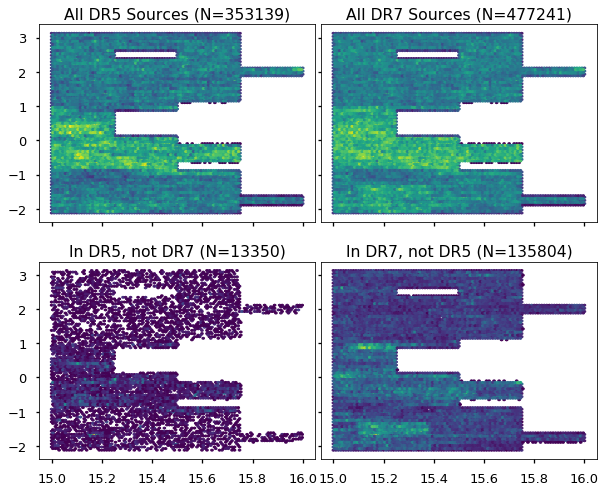

In [12]:
qa_radec()

### Study sources in and around bright stars.

In [80]:
def qa_brightstars(magcut=10):
    istar = np.logical_or(dr7['ref_cat'] == 'T2', dr7['ref_cat'] == 'G2')
    ibright = np.logical_and(istar, dr7['gaia_phot_g_mean_mag'] < magcut)
    instar = dr7['brightstarinblob']
    print('Found {} m<{:.1f} (bright) stars.'.format(np.sum(ibright), magcut))
    print('Found {} sources around all {} Gaia/Tycho-2 stars.'.format(np.sum(instar), np.sum(istar)))

    fig, ax = plt.subplots()
    ax.scatter(dr7['ra'][ibright], dr7['dec'][ibright], s=50, 
               label='Bright Stars (m<{:.1f})'.format(magcut))
    ax.scatter(dr7['ra'][instar], dr7['dec'][instar], s=2, alpha=0.7, 
               label='Sources around All Stars')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')
    
    print('Sources in and around bright stars have type(s) = {}'.format(', '.join(np.unique(dr7['type'][instar]))))

Found 27 m<10.0 (bright) stars.
Found 10422 sources around all 8553 Gaia/Tycho-2 stars.
Sources in and around bright stars have type(s) = PSF 


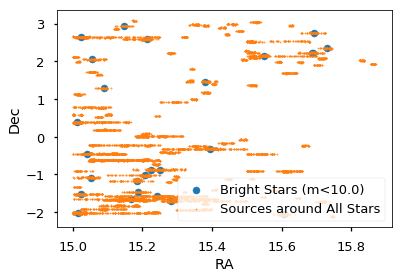

In [81]:
qa_brightstars()

### Study needle galaxies

Look for galaxies with anomalously small minor-to-major axis ratios.

In [72]:
def write_viewer_file(cat, objtype='EXP', dr='DR7'):
    outfile = os.path.join(os.getenv('HOME'), 'needles-{}-{}.fits'.format(objtype.lower(), dr.lower()))
    out = Table()
    out['ra'] = cat['ra']
    out['dec'] = cat['dec']
    out['name'] = cat['objid']
    print('Writing {}'.format(outfile))
    out.write(outfile, format='fits', overwrite=True)

In [73]:
def get_needles(cat, objtype='EXP', dr='DR7'):
    these, ba, radius, rmag = qa_needles(cat, objtype=objtype, dr=dr)[0]
    
    indx = np.where( (ba < 0.2) * (radius > 25) )[0]
    needles = cat[these][indx]
    print('Found {} {} needles with b/a<0.2 and radius>25 arcsec.'.format(
        len(needles), objtype))
    
    write_viewer_file(needles, objtype=objtype, dr=dr)
    
    return needles

In [74]:
def qa_needles(cat, objtype='EXP', dr='DR7'):
    """Try to identify needles based on their size and ellipticity (or b/a ratio).
    
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    
    result = []
    
    if objtype == 'EXP':
        these = (cat['type'] == 'EXP ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
        radius = cat['shapeexp_r'][these]
        e1, e2 = cat['shapeexp_e1'][these], cat['shapeexp_e2'][these]
    elif objtype == 'DEV':
        these = (cat['type'] == 'DEV ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
        radius = cat['shapedev_r'][these]
        e1, e2 = cat['shapedev_e1'][these], cat['shapedev_e2'][these]
    else:
        raise NotImplementedError
            
    ell = np.hypot(e1, e2)
    ba = (1 - ell) / (1 + ell) 
    rmag = 22.5 - 2.5 * np.log10(cat['flux_r'][these])
    result.append( (these, ba, radius, rmag) )
        
    ax1.scatter(rmag, ba, s=3, label=objtype, alpha=0.5)
    ax2.scatter(radius, ba, s=3, label=objtype, alpha=0.5)
    ax3.scatter(rmag, radius, s=3, label=objtype, alpha=0.5)
        
    ax1.set_xlabel('r (AB mag)')
    ax1.set_ylabel('Minor-to-Major Axis Ratio)')
    
    ax2.set_xlabel('Half-light Radius (arcsec)')
    ax2.set_ylabel('Minor-to-Major Axis Ratio)')

    ax3.set_xlabel('r (AB mag)')
    ax3.set_ylabel('Half-light Radius (arcsec)')
    
    ax1.set_xlim(14, 26)
    ax1.set_ylim(0, 1)

    ax2.set_xlim(0, 155)
    ax2.set_ylim(0, 1)
    ax2.set_title('{}: Type = {}'.format(dr, objtype))
    
    ax3.set_xlim(14, 26)
    ax3.set_ylim(0, 155)
    
    fig.subplots_adjust(wspace=0.3)
    
    return result

Found 98 EXP needles with b/a<0.2 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr7.fits


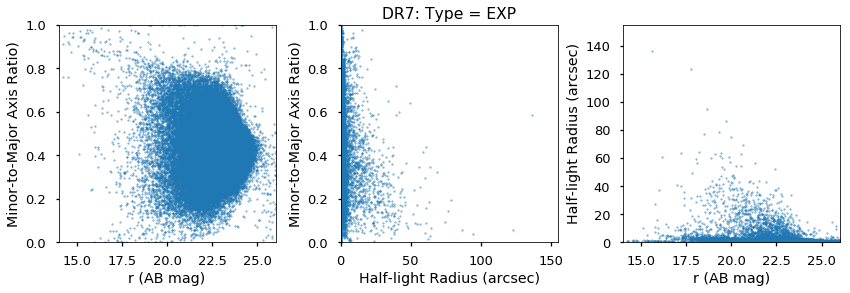

In [75]:
exp_needles = get_needles(dr7, objtype='EXP', dr='DR7')

Found 41 EXP needles with b/a<0.2 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr5.fits


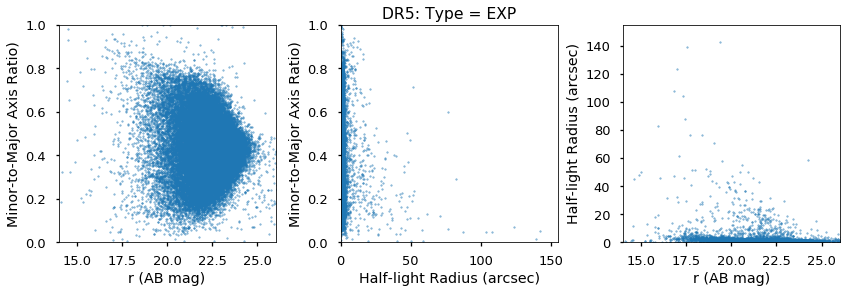

In [77]:
exp_needles = get_needles(dr5, objtype='EXP', dr='DR5')

Found 473 DEV needles with b/a<0.2 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr7.fits


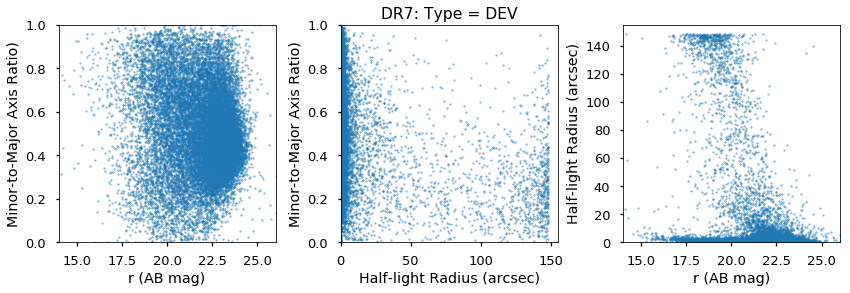

In [78]:
dev_needles = get_needles(dr7, objtype='DEV', dr='DR7')

Found 234 DEV needles with b/a<0.2 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr5.fits


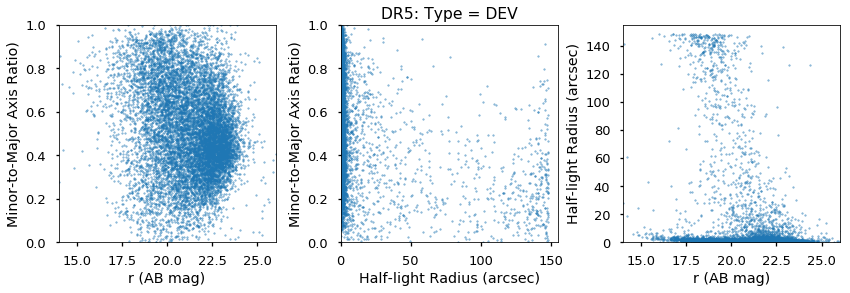

In [79]:
dev_needles = get_needles(dr5, objtype='DEV', dr='DR5')

In [61]:
def needle_cutouts(needles, nperrow=5): 
    baseurl = 'http://legacysurvey.org//viewer-dev/'
        
    nrow = np.ceil(len(needles) / nperrow).astype('int')
    jpgsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(needles):
            i2 = len(needles)
        jpgsplit.append(needles[i1:i2])
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))
    
    fig, ax = plt.subplots(nrow, nperrow, figsize=(3*nperrow, 3*nrow))
    
    ii = 0
    for jpgrow in jpgsplit:
        for obj in jpgrow:
            thisax = ax.flat[ii]
            url = '{}jpeg-cutout?ra={:.9f}1&dec={:.8f}&size=300&layer=decals-dr5'.format(
                baseurl, obj['ra'], obj['dec'])
            print('{}?ra={:.9f}1&dec={:.8f}&size=300&layer=decals-dr5'.format(
                baseurl, obj['ra'], obj['dec']))
            #print(url)
            
            img = skimage.io.imread(url)
            thisax.imshow(img)
            thisax.axis('off')
            ii += 1

Splitting the sample into 4 rows with 5 mosaics per row.
http://legacysurvey.org//viewer-dev/?ra=15.0731713161&dec=2.49994065&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0739138071&dec=2.49687836&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0339492911&dec=2.62163441&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0336895921&dec=2.62250045&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.5074117821&dec=-0.24008948&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.4565225951&dec=1.99841179&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0689725591&dec=1.23840630&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0283036221&dec=1.31022454&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.6143101921&dec=1.48625291&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.1167010011&dec=2.88256542&size=300&layer=dec

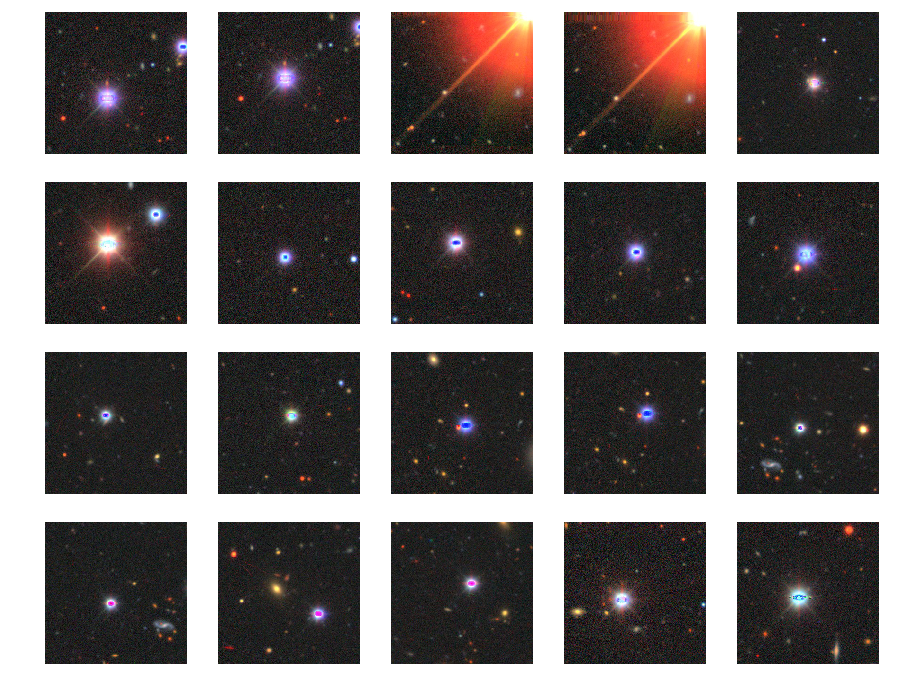

In [63]:
needle_cutouts(exp_needles[:20])

Splitting the sample into 4 rows with 5 mosaics per row.
http://legacysurvey.org//viewer-dev/?ra=15.0953819751&dec=2.40427336&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.1249982361&dec=2.46517322&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.2176171281&dec=2.46939419&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0649763101&dec=2.50207006&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0718079371&dec=2.50045198&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.2425681931&dec=2.50659936&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0081632801&dec=2.52908633&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.0126772721&dec=2.62215105&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.7201327961&dec=-0.34158812&size=300&layer=decals-dr5
http://legacysurvey.org//viewer-dev/?ra=15.5126289751&dec=-0.36176636&size=300&layer=de

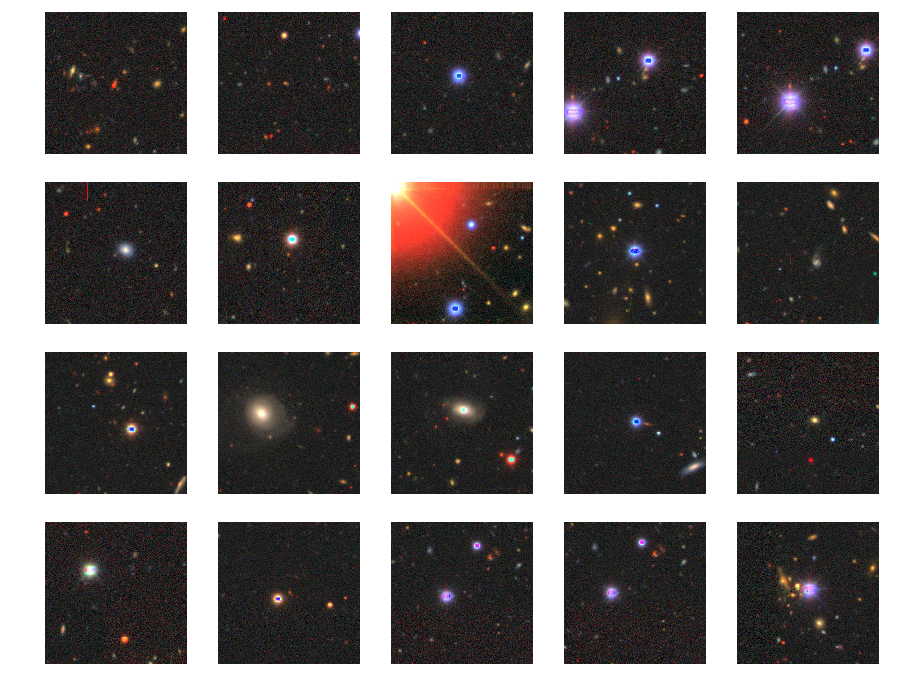

In [64]:
needle_cutouts(dev_needles[:20])